In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 

In [2]:
IMG_HEIGHT = IMG_WIDTH = 224 

# Get the Data 

In [3]:
train_set = pd.read_csv("../datasets/data_support/train.csv", index_col=0)
dev_set = pd.read_csv("../datasets/data_support/validation.csv", index_col=0) 
test_set = pd.read_csv("../datasets/data_support/test.csv", index_col=0)  

In [4]:
train_set.head() 

,paths,chiffon,conventional,cotton,crew_neckline,denim,embroidered,faux,floral,graphic,...,no_dress,no_neckline,pleated,short_sleeve,sleeveless,solid,square_neckline,striped,tight,v_neckline
0,../datasets/big_ds/img-001/img/Vented_Back_Tan...,0,1.0,1,1,0,0,0,0,0,...,1.0,0.0,0,0.0,1,1,0.0,0,0,0
1,../datasets/big_ds/img-001/img/Hooded_Woven_Ja...,0,1.0,0,1,0,0,1,0,0,...,1.0,0.0,0,0.0,0,1,0.0,0,0,0
2,../datasets/big_ds/img-001/img/Strapless_Sweet...,1,1.0,0,0,0,1,0,0,0,...,0.0,1.0,0,0.0,1,0,0.0,0,0,0
3,../datasets/big_ds/img-001/img/Acid_Washed_Den...,0,1.0,0,0,1,0,0,1,0,...,1.0,1.0,0,0.0,1,0,0.0,0,0,0
4,../datasets/big_ds/img-001/img/Trust_Nobody_Mu...,0,1.0,1,1,0,0,0,0,1,...,1.0,0.0,0,0.0,1,0,0.0,0,0,0


In [5]:
train_set.shape, dev_set.shape, test_set.shape

((278022, 27), (5600, 27), (5600, 27))

# 2. Preprocessing Dataset 
- Train set includes None values. 
- Replace them with -1 to do sample weighting. 

In [6]:
train_set[train_set.columns[1:]] = train_set[train_set.columns[1:]].fillna(-1)

In [7]:
np.unique(train_set.iloc[:,1:].values.flatten()), np.unique(test_set.iloc[:,1:].values.flatten()), np.unique(dev_set.iloc[:,1:].values.flatten()), 

(array([-1.,  0.,  1.]),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64))

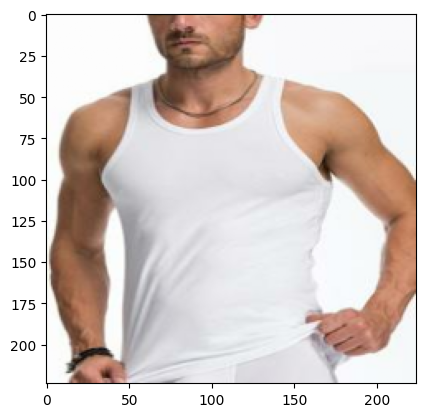

chiffon              0
conventional       1.0
cotton               1
crew_neckline        1
denim                0
embroidered          0
faux                 0
floral               0
graphic              0
knit                 0
lattice              0
leather              0
long_sleeve          0
loose                0
maxi_length          0
mini_length          0
no_dress           1.0
no_neckline        0.0
pleated              0
short_sleeve       0.0
sleeveless           1
solid                1
square_neckline    0.0
striped              0
tight                0
v_neckline           0
Name: 100, dtype: object

In [8]:
from helpers import show_image
show_image(train_set.iat[100,0])
train_set.iloc[100, 1:]

In [9]:
for col in train_set.columns[1:]:
    train_set[col] = train_set[col].astype("int") 

In [10]:
train_set.dtypes

paths              object
chiffon             int32
conventional        int32
cotton              int32
crew_neckline       int32
denim               int32
embroidered         int32
faux                int32
floral              int32
graphic             int32
knit                int32
lattice             int32
leather             int32
long_sleeve         int32
loose               int32
maxi_length         int32
mini_length         int32
no_dress            int32
no_neckline         int32
pleated             int32
short_sleeve        int32
sleeveless          int32
solid               int32
square_neckline     int32
striped             int32
tight               int32
v_neckline          int32
dtype: object

# 3. Train and Train-Dev Set Split 

- Train Set 
- Train Dev Set 
- Dev Set 
- Test Set 

In [11]:
from sklearn.model_selection import train_test_split 
train_set.shape 

(278022, 27)

In [12]:
X_train, X_train_dev, y_train, y_train_dev = train_test_split(train_set.iloc[:, 0], train_set.iloc[:, 1:], test_size=0.05, random_state=47) 

In [13]:
X_train.shape, X_train_dev.shape 

((264120,), (13902,))

In [14]:
train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True) 
train_dev_set = pd.concat([X_train_dev, y_train_dev], axis=1).reset_index(drop=True) 

In [15]:
X_train = train_set.iloc[:, 0] 
y_train = train_set.iloc[:, 1:]

X_train_dev = train_dev_set.iloc[:, 0] 
y_train_dev = train_dev_set.iloc[:, 1:] 

X_dev = dev_set.iloc[:, 0] 
y_dev = dev_set.iloc[:, 1:]

X_test = test_set.iloc[:, 0] 
y_test = test_set.iloc[:, 1:] 

# 4. Keras Data Generators 

In [16]:
# merged_all_classes = [] 
# for idx, row in y_train.iterrows():
#     merged_all_classes.append([col for col, val in row.items() if val == 1])

# y_train = pd.Series(merged_all_classes, index=y_train.index, name="labels") 

# merged_all_classes = [] 
# for idx, row in y_train_dev.iterrows():
#     merged_all_classes.append([col for col, val in row.items() if val == 1])

# y_train_dev = pd.Series(merged_all_classes, index=y_train_dev.index, name="labels") 

# merged_all_classes = [] 
# for idx, row in y_dev.iterrows():
#     merged_all_classes.append([col for col, val in row.items() if val == 1])

# y_dev = pd.Series(merged_all_classes, index=y_dev.index, name="labels") 


# merged_all_classes = [] 
# for idx, row in y_test.iterrows():
#     merged_all_classes.append([col for col, val in row.items() if val == 1])

# y_test = pd.Series(merged_all_classes, index=y_test.index, name="labels") 

In [17]:
# train_data_flow_df = pd.concat([
#     X_train, 
#     y_train
# ], axis=1)

# train_dev_data_flow_df = pd.concat([
#     X_train_dev, 
#     y_train_dev
# ], axis=1)

# dev_data_flow_df = pd.concat([
#     X_dev, 
#     y_dev
# ], axis=1)

# test_data_flow_df = pd.concat([
#     X_test, 
#     y_test
# ], axis=1) 

In [18]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# train_gen = ImageDataGenerator() # train set 
# train_dev_gen = ImageDataGenerator() # train dev set 
# dev_gen = ImageDataGenerator()  # dev set 
# test_gen = ImageDataGenerator() # test set 

In [19]:
# train = train_gen.flow_from_dataframe(
#     dataframe=train_data_flow_df, 
#     directory="", 
#     x_col="paths", 
#     y_col="labels", 
#     class_mode='categorical', 
#     target_size=(IMG_HEIGHT, IMG_WIDTH))

# train_dev = train_dev_gen.flow_from_dataframe(
#     dataframe=train_dev_data_flow_df, 
#     directory="", 
#     x_col="paths", 
#     y_col="labels", 
#     class_mode='categorical', 
#     target_size=(IMG_HEIGHT, IMG_WIDTH))

# dev = dev_gen.flow_from_dataframe(
#     dataframe=dev_data_flow_df, 
#     directory="", 
#     x_col="paths", 
#     y_col="labels", 
#     class_mode='categorical', 
#     target_size=(IMG_HEIGHT, IMG_WIDTH))

# test = test_gen.flow_from_dataframe(
#     dataframe=test_data_flow_df, 
#     directory="", 
#     x_col="paths", 
#     y_col="labels", 
#     class_mode='categorical', 
#     target_size=(IMG_HEIGHT, IMG_WIDTH))

# 4.b Custom Data Generator 
The Keras Generators don't take into account the missing values. 
Create a Custome Data Generator that generates the values by handling the missing values (-1s ) 

In [20]:
class CustomDataGenerator:
    def __init__(self, shape = [224, 224]) -> None:
        self.shape = shape
        pass 


    def preprocess_image(self, path):
        img = tf.io.read_file(path) 
        img = tf.image.decode_image(img, channels=3) 
        img = tf.image.resize(img, self.shape) 
        return img.numpy() 
    
    def flow_from_dataframe(self, X: pd.Series, y: pd.DataFrame, batch_size=32, epoch=5): 
        images, labels = [], [] 
        while True: 
            for point in X.index:
                images.append(self.preprocess_image(X[point]))
                labels.append(y.iloc[point, :].values.tolist())

                if len(images) >= batch_size: 
                    yield np.array(images).astype("float32"), np.array(labels).astype("float32") 
                    images, labels = [], [] 
            
            epoch = epoch - 1 
            if epoch == 0:
                break

In [21]:
g = CustomDataGenerator() 
gen = g.flow_from_dataframe(X_dev, y_dev) 
b = next(gen)

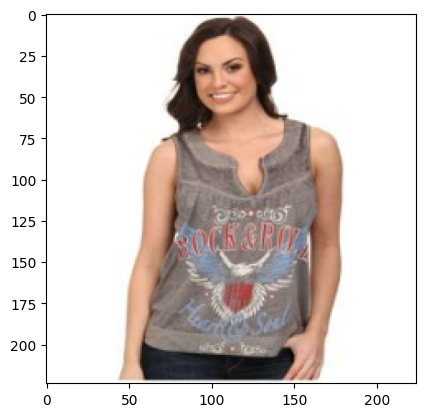

(array([0., 1.], dtype=float32), array([640, 192], dtype=int64))

In [22]:
import matplotlib.pyplot as plt 
import random as rnd 
b = next(gen)
plt.imshow(b[0][rnd.randint(0, 31)] / 255)
plt.show() 
np.unique(b[1].flatten(), return_counts=True)

# 5. Model Building 

## Model 1: Backbone Efficient Net B0

In [31]:
class CustomPrecision(tf.keras.metrics.Precision):
    def __init__(self, name='cs_precision', **kwargs):
        super(CustomPrecision, self).__init__(name="cs_precision") 
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.not_equal(y_true, -1)  # Create a mask to ignore missing labels
        y_true = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_pred = tf.where(mask, y_pred, tf.zeros_like(y_pred))
        super().update_state(y_true, y_pred, sample_weight)


class CustomRecall(tf.keras.metrics.Recall):
    def __init__(self, name='cs_recall', **kwargs):
        super(CustomRecall, self).__init__(name="cs_recall") 
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.not_equal(y_true, -1)  # Create a mask to ignore missing labels
        y_true = tf.where(mask, y_true, tf.zeros_like(y_true))
        y_pred = tf.where(mask, y_pred, tf.zeros_like(y_pred))
        super().update_state(y_true, y_pred, sample_weight)

In [50]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False

In [51]:
inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)) 
x = base_model(inputs) 
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
outputs = tf.keras.layers.Dense(train_set.shape[1] -1, 
                                activation=tf.keras.activations.sigmoid,
                                kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))(x)
model_1 = tf.keras.Model(inputs, outputs) 

In [52]:
from tensorflow.keras import backend as K 

def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, -1), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)

In [53]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=masked_loss_function,
              metrics=[
                  CustomRecall(),
                  CustomPrecision() 
              ])

In [54]:
checkpoint_path = "checkpoints/ADDING_MORE_DATA/Model_1dd/checkpoint-{epoch:01d}.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         verbose=1)

batch_size = 32 
epoch = 10
gen = CustomDataGenerator() 
train = gen.flow_from_dataframe(X_train, y_train, batch_size=batch_size, epoch=epoch) 
train_dev = gen.flow_from_dataframe(X_train_dev, y_train_dev, batch_size=batch_size, epoch=epoch) 


history_model_1 = model_1.fit(
        train,
        steps_per_epoch=np.floor(len(X_train) / batch_size),  
        validation_data=train_dev,
        validation_steps=np.floor(len(X_dev) / batch_size),
        epochs=10,
        callbacks=[checkpoint_callback])

Epoch 1/10
8253/8253 [==============================] - ETA: 0s - loss: 0.0886 - cs_recall: 0.6368 - cs_precision: 0.9425
Epoch 1: saving model to checkpoints/ADDING_MORE_DATA/Model_1dd\checkpoint-1.ckpt
8253/8253 [==============================] - 15330s 2s/step - loss: 0.0886 - cs_recall: 0.6368 - cs_precision: 0.9425 - val_loss: 0.0857 - val_cs_recall: 0.6419 - val_cs_precision: 0.9416
Epoch 2/10
8253/8253 [==============================] - ETA: 0s - loss: 0.0846 - cs_recall: 0.6473 - cs_precision: 0.9410
Epoch 2: saving model to checkpoints/ADDING_MORE_DATA/Model_1dd\checkpoint-2.ckpt
8253/8253 [==============================] - 15363s 2s/step - loss: 0.0846 - cs_recall: 0.6473 - cs_precision: 0.9410 - val_loss: 0.0876 - val_cs_recall: 0.6359 - val_cs_precision: 0.9349
Epoch 3/10
8253/8253 [==============================] - ETA: 0s - loss: 0.0838 - cs_recall: 0.6502 - cs_precision: 0.9400
Epoch 3: saving model to checkpoints/ADDING_MORE_DATA/Model_1dd\checkpoint-3.ckpt
8253/8253 [=

In [55]:
def calculate_f1(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

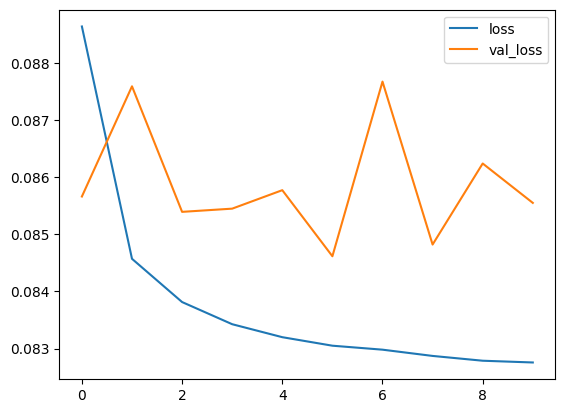

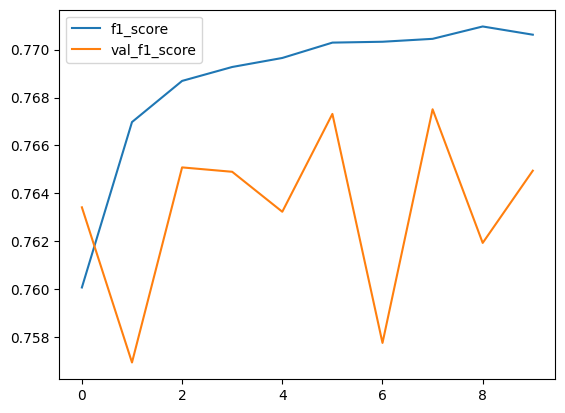

In [56]:
import matplotlib.pyplot as plt 

hist2 = pd.DataFrame(history_model_1.history).reset_index(drop=True)
hist2.columns = hist2.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist2['f1_score'] = hist2.apply(lambda row: calculate_f1(row["cs_precision"], row["cs_recall"]), axis=1)
hist2['val_f1_score'] = hist2.apply(lambda row: calculate_f1(row["val_cs_precision"], row["val_cs_recall"]), axis=1)
hist2[["loss", "val_loss"]].plot()
plt.show() 
hist2[["f1_score", "val_f1_score"]].plot()
plt.show()

In [60]:
model_1.layers[1].trainable = False 

for layer in model_1.layers[1].layers[-15:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model_1.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=masked_loss_function,
              metrics=[
                  CustomRecall(),
                  CustomPrecision() 
              ])


np.array([l.trainable for l in model_1.layers[1].layers]).astype("int").sum()

11

In [61]:
batch_size = 32 
initial_epoch = 10 
epoch = initial_epoch + 20 
gen = CustomDataGenerator() 
train = gen.flow_from_dataframe(X_train, y_train, batch_size=batch_size, epoch=epoch) 
train_dev = gen.flow_from_dataframe(X_train_dev, y_train_dev, batch_size=batch_size, epoch=epoch) 


history_model_1_fine = model_1.fit(
        train,
        steps_per_epoch=np.floor(len(X_train) / batch_size),  
        validation_data=train_dev,
        validation_steps=np.floor(len(X_dev) / batch_size),
        epochs=epoch,
        initial_epoch = initial_epoch, 
        callbacks=[checkpoint_callback])

Epoch 11/30
8253/8253 [==============================] - ETA: 0s - loss: 0.0827 - cs_recall: 0.6547 - cs_precision: 0.9381
Epoch 11: saving model to checkpoints/ADDING_MORE_DATA/Model_1dd\checkpoint-11.ckpt
8253/8253 [==============================] - 13722s 2s/step - loss: 0.0827 - cs_recall: 0.6547 - cs_precision: 0.9381 - val_loss: 0.0851 - val_cs_recall: 0.6521 - val_cs_precision: 0.9341
Epoch 12/30
8253/8253 [==============================] - ETA: 0s - loss: 0.0827 - cs_recall: 0.6547 - cs_precision: 0.9376
Epoch 12: saving model to checkpoints/ADDING_MORE_DATA/Model_1dd\checkpoint-12.ckpt
8253/8253 [==============================] - 12864s 2s/step - loss: 0.0827 - cs_recall: 0.6547 - cs_precision: 0.9376 - val_loss: 0.0874 - val_cs_recall: 0.6380 - val_cs_precision: 0.9290
Epoch 13/30
8253/8253 [==============================] - ETA: 0s - loss: 0.0827 - cs_recall: 0.6545 - cs_precision: 0.9377
Epoch 13: saving model to checkpoints/ADDING_MORE_DATA/Model_1dd\checkpoint-13.ckpt
825

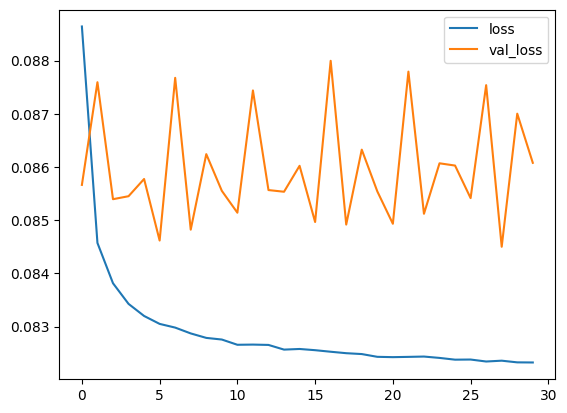

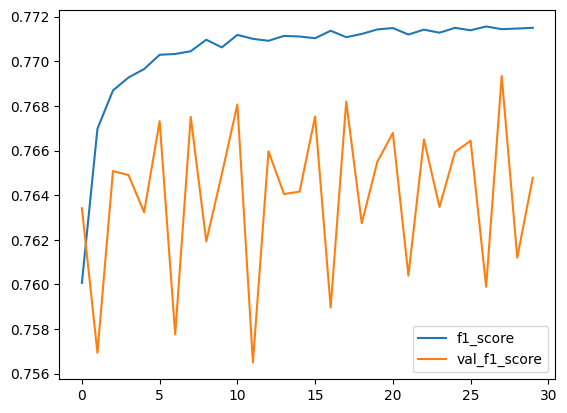

In [62]:
hist2 = pd.concat([pd.DataFrame(history_model_1.history), pd.DataFrame(history_model_1_fine.history)]).reset_index(drop=True)
hist2.columns = hist2.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist2['f1_score'] = hist2.apply(lambda row: calculate_f1(row["cs_precision"], row["cs_recall"]), axis=1)
hist2['val_f1_score'] = hist2.apply(lambda row: calculate_f1(row["val_cs_precision"], row["val_cs_recall"]), axis=1)
hist2[["loss", "val_loss"]].plot()
plt.show() 
hist2[["f1_score", "val_f1_score"]].plot()
plt.show()

In [66]:
gen_test = CustomDataGenerator() 
dev = gen.flow_from_dataframe(X_dev, y_dev, batch_size=batch_size, epoch=epoch) 
test = gen.flow_from_dataframe(X_test, y_test, batch_size=batch_size, epoch=epoch) 


model_1.evaluate(dev)

5250/5250 [==============================] - 8946s 2s/step - loss: 0.6146 - cs_recall: 0.3333 - cs_precision: 0.7796


[0.6146499514579773, 0.3332737982273102, 0.7796421647071838]

In [67]:
model_1.evaluate(test)

5250/5250 [==============================] - 8773s 2s/step - loss: 0.6113 - cs_recall: 0.3336 - cs_precision: 0.7790


[0.6112807393074036, 0.3335714340209961, 0.7790366411209106]

# Model 2: Efnet with extra layers 

In [68]:
from tensorflow.keras import layers 

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.4, name="after_base_dropout")(x) 
x = layers.Dense(32, activation='relu', name='custom_dense')(x) 
x = layers.Dropout(0.3, name="after_custom_dense_dropout")(x) 
outputs = layers.Dense(train_set.shape[1] -1, activation='softmax', name='output')(x)
model_2 = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/ADDING_MORE_DATA/model_2t/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_2.compile(loss=masked_loss_function, 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  CustomRecall(),
                  CustomPrecision() ]) 


batch_size =64
epoch = 10
gen = CustomDataGenerator() 
train = gen.flow_from_dataframe(X_train, y_train, batch_size=batch_size, epoch=epoch) 
train_dev = gen.flow_from_dataframe(X_train_dev, y_train_dev, batch_size=batch_size, epoch=epoch) 


history_model_2 = model_2.fit(
        train,
        steps_per_epoch=np.floor(len(X_train) / batch_size),  
        validation_data=train_dev,
        validation_steps=np.floor(len(X_dev) / batch_size),
        epochs=10,
        callbacks=[checkpoint_callback])

Epoch 1/10
4126/4126 [==============================] - 13218s 3s/step - loss: 0.1239 - cs_recall: 0.4773 - cs_precision: 0.9919 - val_loss: 0.1109 - val_cs_recall: 0.5618 - val_cs_precision: 0.9937
Epoch 2/10
4126/4126 [==============================] - 13085s 3s/step - loss: 0.1148 - cs_recall: 0.5576 - cs_precision: 0.9924 - val_loss: 0.1128 - val_cs_recall: 0.5594 - val_cs_precision: 0.9947
Epoch 3/10
4126/4126 [==============================] - 12838s 3s/step - loss: 0.1138 - cs_recall: 0.5638 - cs_precision: 0.9919 - val_loss: 0.1106 - val_cs_recall: 0.5678 - val_cs_precision: 0.9926
Epoch 4/10
4126/4126 [==============================] - 12722s 3s/step - loss: 0.1134 - cs_recall: 0.5627 - cs_precision: 0.9919 - val_loss: 0.1098 - val_cs_recall: 0.5644 - val_cs_precision: 0.9931
Epoch 5/10
4126/4126 [==============================] - 12753s 3s/step - loss: 0.1131 - cs_recall: 0.5626 - cs_precision: 0.9920 - val_loss: 0.1111 - val_cs_recall: 0.5634 - val_cs_precision: 0.9937
Epoch

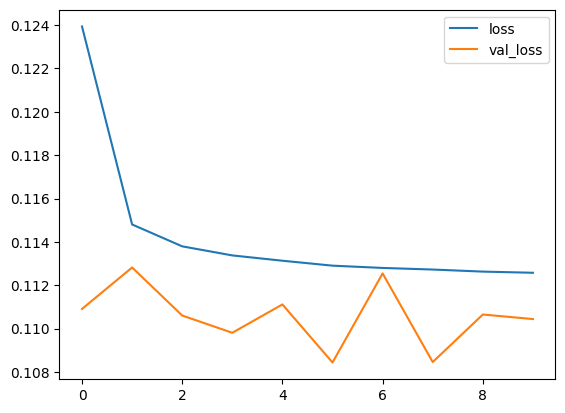

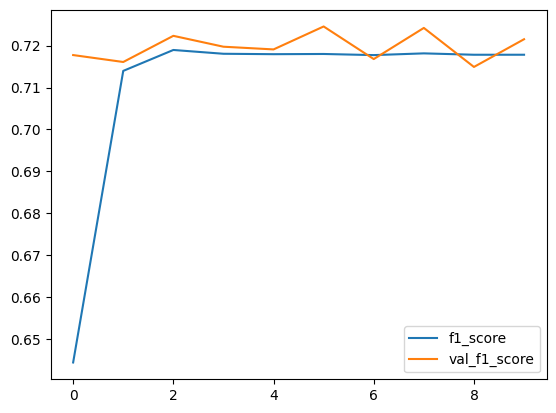

In [69]:
hist2 = pd.concat([pd.DataFrame(history_model_2.history)]).reset_index(drop=True)
hist2.columns = hist2.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist2['f1_score'] = hist2.apply(lambda row: calculate_f1(row["cs_precision"], row["cs_recall"]), axis=1)
hist2['val_f1_score'] = hist2.apply(lambda row: calculate_f1(row["val_cs_precision"], row["val_cs_recall"]), axis=1)
hist2[["loss", "val_loss"]].plot()
plt.show() 
hist2[["f1_score", "val_f1_score"]].plot()
plt.show()

In [83]:
model_2.layers[1].trainable = False 

for layer in model_2.layers[1].layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_2.compile(loss=masked_loss_function, 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                CustomRecall(),
                CustomPrecision()]) 

sum(np.array([layer.trainable for layer in model_2.layers[1].layers]).astype("int")), len(model_2.layers[1].layers)

(11, 238)

In [81]:
# model_2.load_weights("./checkpoints/ADDING_MORE_DATA/model_2t/checkpoint-10.ckpt")

In [84]:
initial_epoch = 10 
epoch = initial_epoch + 20  

gen = CustomDataGenerator() 
train = gen.flow_from_dataframe(X_train, y_train, batch_size=batch_size, epoch=epoch - initial_epoch) 
train_dev = gen.flow_from_dataframe(X_dev, y_dev, batch_size=batch_size, epoch=epoch - initial_epoch) 


model_2_history_fine = model_2.fit(
        train,
        steps_per_epoch=np.floor(len(X_train) / batch_size),  
        validation_data=train_dev,
        validation_steps=np.floor(len(X_train_dev) / batch_size),
        epochs=epoch,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint_callback])

Epoch 11/30
 161/4126 [>.............................] - ETA: 3:54:46 - loss: 0.1136 - cs_recall: 0.5653 - cs_precision: 0.9919